### Imports

In [24]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
import time
from array import array
from scipy.interpolate import interp1d
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
import itertools
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

In [30]:
m_D0 = 1.86483
m_Dst = 2.01026
m_Dstst = 2.430

In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

# Load data

In [6]:
locRD = '../data/cmsRD/skimmed/TnP_Bp2DststMuNu_200522_All.root'
dsRD = rtnp.root2array(locRD)

# datasets_loc = glob('../data/cmsRD/ParkingBPH*/*TagAndProbe_Bp2MuNuDstst_Pip_200522_CAND.root'
# lumi_tot = getLumiByTrigger(datasets_loc, 'Mu12_IP6', verbose=True)
CMS_lumi.integrated_lumi = 0#lumi_tot

In [7]:
locMC = '../data/cmsMC_private/BP_Tag_Bp_MuNuDstst_Hardbbbar_evtgen_ISGW2_PUc0_10-2-3/ntuples_TagAndProbe_Bp_MuNuDstst/skimmed/All.root'
dsMC = rtnp.root2array(locMC)

Explore kinematic distribution to choose a binning

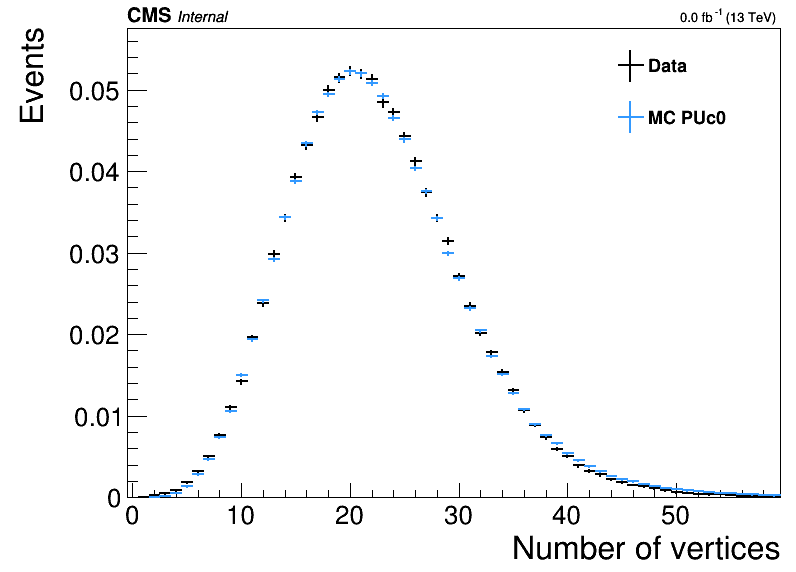

In [9]:
h_list = []
h = create_TH1D(dsRD['N_vtx'], name='h',
                title='Data',
                axis_title=['Number of vertices', 'Normalized events'],
                binning=[60, -0.5, 59.5]
               )
h_list.append(h)

h = create_TH1D(dsMC['N_vtx'], name='h2', title='MC PUc0', binning=h_list[0].binning)
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()

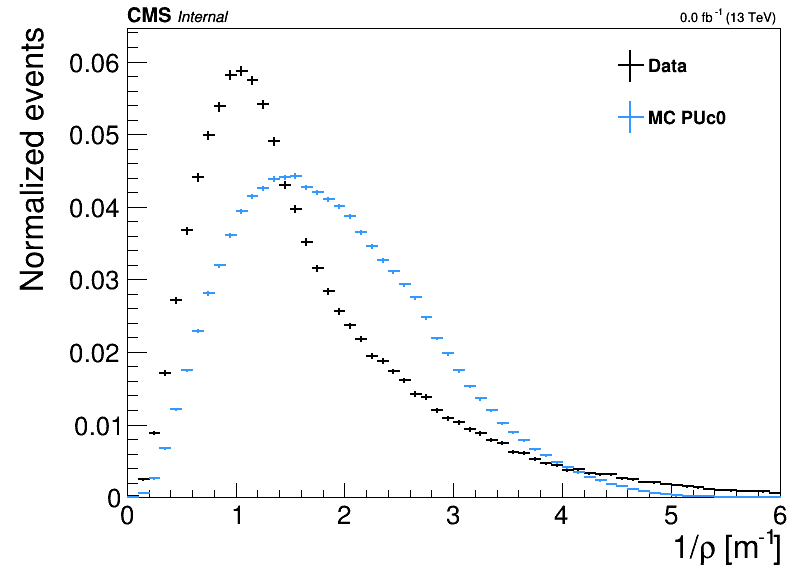

In [12]:
h_list = []
h = create_TH1D(0.3*3.8/dsRD['expPis_pt'], name='h',
                title='Data',
                axis_title=['1/#rho [m^{-1}]', 'Normalized events'],
                binning=[60, 0, 6]
               )
h_list.append(h)

h = create_TH1D(0.3*3.8/dsMC['expPis_pt'], name='h2', title='MC PUc0', binning=h_list[0].binning)
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()

# Efficiency functions

In [101]:
def fitPoly(h, maskLim, deg, rooFitNorm=False, verbose=False):
    x = []
    y = []
    yerr = []
    for i in range(1, h.GetNbinsX()+1):
        xx = h.GetBinCenter(i)
        if xx < maskLim[0] or xx > maskLim[1]:
            x.append(xx)
            y.append(h.GetBinContent(i))
            yerr.append(h.GetBinError(i))
    p = np.polyfit(x,y, deg, w=1./np.array(yerr))
    if verbose:
        plt.errorbar(x,y, yerr=yerr, fmt='.b')
        plt.plot(x, np.polyval(p, x), '--r')
    if rooFitNorm:
        p /= p[-1]
    return np.flip(p, axis=0)

In [115]:
def fitResonance(x, varName, xlims, nbins,
                 p0={'mean': 0, 'sigmaN':[], 'sigmaW':[], 'bkg':[]},
                 bkgType='pol0',
                 units='MeV', rightText=None, verbose=False):
    h = create_TH1D(x, name='h', title='',
                    axis_title=[varName+' [GeV]', 'Events'],
                    binning=[nbins, xlims[0], xlims[1]]
                   )
    if h.GetMinimum() == 0:
        if verbose: print 'Trying reduce the number of bins'
        nbins = int(nbins*0.5)
        h = create_TH1D(x, name='h', title='',
                        axis_title=[varName+' [GeV]', 'Events'],
                        binning=[nbins, xlims[0], xlims[1]]
                       )
    h.Sumw2()
    N_tot = h.Integral()

    mass = rt.RooRealVar('mass', varName, xlims[0], xlims[1], units)

    mean = rt.RooRealVar('mean', '#mu', p0['mean'], xlims[0], xlims[1])
    sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', p0['sigmaN'][0], p0['sigmaN'][1], p0['sigmaN'][2]) 
    sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', p0['sigmaW'][0], p0['sigmaW'][1], p0['sigmaW'][2]) 
    gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
    gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
    fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.0, 1.0)
    pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))
    nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 10*N_tot)
    pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)
    
    if bkgType=='exp':
        lam = rt.RooRealVar('lam', '#lambda', p0['bkg'][0], p0['bkg'][1], p0['bkg'][2], units+'^{-1}')
        pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)
    elif bkgType.startswith('pol'):
        deg = int(bkgType[3:])
        if verbose: print 'Fitting with polinomial (degree = {})'.format(deg)
        if p0['bkg'] == 'auto':
            p0['bkg'] = fitPoly(h, p0['sigmaW'][1:], deg, True)
        bkgRooVar = []
        for iv in range(1, deg+1):
            bkgRooVar.append(rt.RooRealVar('a'+str(iv), 'a'+str(iv), p0['bkg'][iv]))
        pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(*bkgRooVar), 1)
    else:
        raise
    nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 10*N_tot)
    pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

    pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
    
    unbinnedUsed = False
    if h.GetMinimum() == 0 or h.Integral() < 2*h.binning[0]:
        if verbose: print 'Using unbinned likelihood ({:.0f} events)'.format(h.Integral())
        auxdf = pd.DataFrame(x, columns=['mass'])
        T = rtnp.array2tree(auxdf.to_records())
        data = rt.RooDataSet('d', 'data', T, rt.RooArgSet(mass))
        unbinnedUsed = True
    else:
        data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)
        if verbose: print 'Using binned likeihood'
    
    fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())
    
    frame = mass.frame(rf.Title(""), rf.Bins(h.binning[0]))
    dataPlot = data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), 
                           rf.MarkerColor(1), rf.LineColor(1), rf.MarkerStyle(15))
    
    pdf_tot.plotOn(frame, rf.LineColor(rt.kBlack), rf.LineWidth(1))

    dof = fr.floatParsFinal().getSize()
    chi2 = frame.chiSquare(dof)*dof
    pval = rt.ROOT.Math.chisquared_cdf_c(chi2, dof)
    if verbose: print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2, dof, pval)

    pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
    pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

    x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.7
    x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.95
    pTxt = rt.TPaveText(x_min, 0.35*dataPlot.GetMaximum(), x_max, 0.85*dataPlot.GetMaximum())
    pTxt.SetBorderSize(0)
    pTxt.SetFillStyle(0)
    pTxt.SetTextAlign(11)
    pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2, dof, pval))
    pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

    pTxt.AddText('#mu = {:.1f} +/- {:.1f} '.format(mean.getVal(), mean.getError()) + units)
    pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} '.format(sigmaN.getVal(), sigmaN.getError()) + units)
    pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} '.format(sigmaW.getVal(), sigmaW.getError()) + units)
    pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))
    frame.addObject(pTxt)
    
    if not rightText is None:
        x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.65
        x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.95
        pTxtR = rt.TPaveText(x_min, 0.5*dataPlot.GetMaximum(), x_max, 0.7*dataPlot.GetMaximum())
        pTxtR.SetBorderSize(0)
        pTxtR.SetFillStyle(0)
        for s in rightText:
            pTxtR.AddText(s)
        frame.addObject(pTxtR)
    
    return frame, [nsig.getVal(), nsig.getError()], [chi2, dof, pval], h

Test fit function

Fitting with polinomial (degree = 2)
Using binned likeihood
chi2: 1120.8/6 0.000


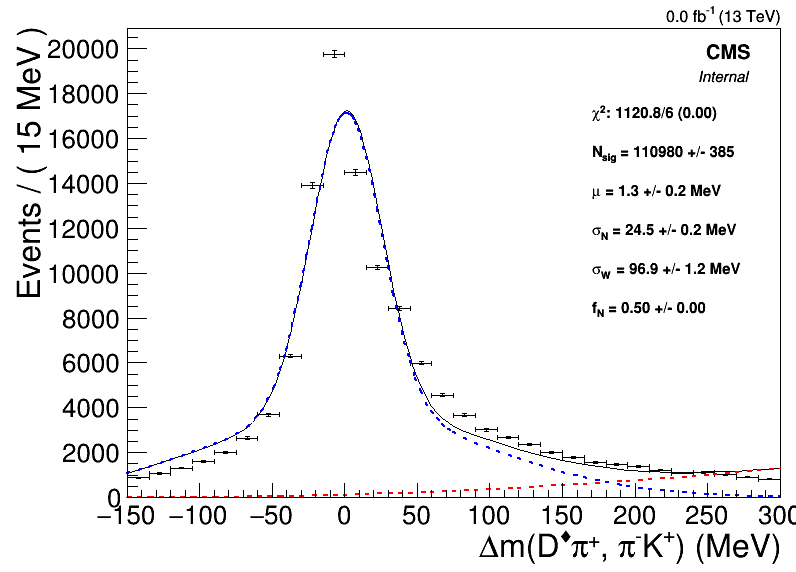

In [123]:
# sel = np.logical_and(np.abs(dsRD['N_vtx']-15) < 2, 0.3*3.8/dsRD['expPis_pt'] < 1.2)
sel = 0.3*3.8/dsMC['expPis_pt'] < 1.2
x = 1e3*(dsMC['dm_expDstpip_pik'][sel] - (m_Dstst - m_D0))

out = fitResonance(x, '#Deltam(D^{#diamond}#pi^{+}, #pi^{-}K^{+})', [-150, 300], 30,
                   p0={'mean': 0, 'sigmaN':[20., 1., 100.], 'sigmaW':[350., 10., 500.], 'bkg':'auto'},
                   bkgType='pol2',
                   units='MeV', rightText=None, verbose=True)
c = rt.TCanvas('c', 'c', 50, 50, 800,600)
c.SetTickx(0)
c.SetTicky(0)
c.Divide(2)

out[0].Draw()
CMS_lumi.CMS_lumi(c, -1, 33)
c.Draw()

In [45]:
def analyzeBin(idx, reloadTree=True, verbose=False):
    print idx, 'started'
    if reloadTree:
        fileTmp = None
        if len(dataset_loc) == 1:
            fileTmp = rt.TFile(dataset_loc[0], 'READ')
            T = fileTmp.Get('TnP/T')
        else:
            raise
    psCut = []
    lim = {}
    psStrings = []
    for n, i in idx.iteritems():
        lim[n] = [binning[n][i], binning[n][i+1]]
        psCut.append('fabs(fabs(mProbe_{}) - {}) < {}'.format(n, np.mean(lim[n]), 0.5*(lim[n][1]-lim[n][0])))
        psS = '{:.1f} < '.format(lim[n][0])
        if n == 'eta':
            psS += '|#eta|'
        elif n == 'pt':
            psS += 'p_{T}/GeV'
        elif n == 'sigdxy':
            psS += 'IP'
        else: 
            raise
        psS += ' < {:.1f}'.format(lim[n][1])
        psStrings.append(psS)
    psCut = ' && '.join(psCut + ['prescale'+probeTrigger[4:] + ' > 0'])

    rt.TGaxis.SetMaxDigits(3)

    if verbose: 
        print ' --- Total ---'
        print psCut
    st = time.time()
    frameTot, nSigTot, pValTot = fitJpsi(T, psCut, probeTrigger,
                                         rightText=['All '] + psStrings,
                                         verbose=verbose
                                        )
    if verbose: 
        print 'Time: {:.1f} s'.format(time.time()-st)
        print ' --- Passed ---'
        print psCut + ' && mProbe_' + probeTrigger + ' == 1'
    st = time.time()
    framePassed, nSigPass, pValPass = fitJpsi(T, psCut + ' && mProbe_' + probeTrigger + ' == 1', probeTrigger,
                                              rightText=['Passed '+probeTrigger] + psStrings,
                                              verbose=verbose
                                             )
    if verbose: print 'Time: {:.1f} s'.format(time.time()-st)
    cTag = '_' + '_'.join([str(idx[k]) for k in np.sort(idx.keys())])
    c = rt.TCanvas('c'+cTag, 'c'+cTag, 50, 50, 1200, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    c.Divide(2)

    p = c.cd(1)
    frameTot.Draw()
    CMS_lumi.CMS_lumi(p, -1, 33)
    p = c.cd(2)
    framePassed.Draw()
    CMS_lumi.CMS_lumi(p, -1, 33)
    
    imgLoc = '../data/calibration/triggerScaleFactors/figFit'+dataset+'/{}'.format(probeTrigger)
    if not os.path.isdir(imgLoc):
        os.makedirs(imgLoc)
        print 'Creating', imgLoc
    c.SaveAs(imgLoc + '/'+ '_'.join([k+str(idx[k]) for k in np.sort(idx.keys())]) +'.png')
    if reloadTree and not fileTmp is None:
        fileTmp.Close()
    print idx, 'done'
    return c, idx, nSigTot, pValTot, nSigPass, pValPass

# Run the fit in each bin

In [ ]:
dataset = 'MC'
if dataset == 'RD':
    CMS_lumi.extraText = "     Internal"
    T = treeRD
    dataset_loc = glob('../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_TagAndProbe_200206_CAND.root')
elif dataset == 'MC':
    CMS_lumi.extraText = "     Simulation Internal"
    T = treeMC20
    dataset_loc = glob('../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3/ntuples_TagAndProbe/merged/*.root')
    

In [ ]:
# probeTrigger = 'HLT_Mu7_IP4'
# binning = {'pt': array('d', [6, 7, 7.3, 7.6, 8, 9, 12, 20]),
#            'eta': array('d', [0, 0.4, 0.8, 1.5]),
#            'sigdxy': array('d', [3, 4, 4.5, 6, 10, 200])
#           }
# triggerLimits = [[1, 4], [1, 4]]

# probeTrigger = 'HLT_Mu9_IP6'
# binning = {'pt': array('d', [8, 8.5, 9, 10, 11, 12, 20]),
#            'eta': array('d', [0, 0.4, 0.8, 1.5]),
#            'sigdxy': array('d', [3, 6, 7, 10, 200])
#           }
# triggerLimits = [[2, 4], [1, 3]]

probeTrigger = 'HLT_Mu12_IP6'
binning = {'pt': array('d', [10, 11, 12, 13, 15, 20, 30, 50, 200]),
           'eta': array('d', [0, 0.4, 0.8, 1.5]),
           'sigdxy': array('d', [3, 6, 7, 10, 200])
          }
triggerLimits = [[2, 7], [1, 3]]

In [ ]:
h2 = {}
for var, cat in itertools.product(['N', 'Chi2'], ['tot', 'pass']):
    h2[var+cat] = rt.TH3D('h2'+var+cat, '', 
                          len(binning['pt'])-1, binning['pt'], 
                          len(binning['sigdxy'])-1, binning['sigdxy'], 
                          len(binning['eta'])-1, binning['eta'],)

In [ ]:
start = time.time()
testOutput = analyzeBin({'pt': 2, 'sigdxy':2, 'eta':0}, verbose=True)
testOutput[0].Draw()
print 'Total time: {:.1f} mins'.format((time.time() - start)/60.)

In [ ]:
inputs = []
for ipt in range(len(binning['pt'])-1):
    for iip in range(len(binning['sigdxy'])-1):
        for ieta in range(len(binning['eta'])-1):
            idx = {'pt': ipt, 'sigdxy':iip, 'eta': ieta}
            inputs.append(idx)
print 'Total bins:', len(inputs)

In [ ]:
multiCpu = True
start = time.time()
if multiCpu:
    N_max = max(1, multiprocessing.cpu_count() - 4)
    N_request = min(len(inputs), N_max)
    print 'Parallelization factor:', N_request
    p = multiprocessing.Pool(N_request)
    output = p.map(analyzeBin, inputs)
else:
    output = []
    for i in inputs:
        output.append(analyzeBin(i, reloadTree=False, verbose=True))
print 'Total time: {:.1f} mins'.format((time.time() - start)/60.)

In [ ]:
for c, idx, nSigTot, pValTot, nSigPass, pValPass in output:
    ip = idx['pt']+1
    ii = idx['sigdxy']+1
    ie = idx['eta']+1
    h2['Ntot'].SetBinContent(ip, ii, ie, int(np.ceil(nSigTot[0])))
    h2['Ntot'].SetBinError(h2['Ntot'].GetBin(ip, ii, ie), nSigTot[1])
    h2['Chi2tot'].SetBinContent(ip, ii, ie, pValTot[0])
    h2['Chi2tot'].SetBinError(h2['Chi2tot'].GetBin(ip, ii, ie), pValTot[1])
    h2['Npass'].SetBinContent(ip, ii, ie, int(nSigPass[0]))
    h2['Npass'].SetBinError(h2['Npass'].GetBin(ip, ii, ie), nSigPass[1])
    h2['Chi2pass'].SetBinContent(ip, ii, ie, pValPass[0])
    h2['Chi2pass'].SetBinError(h2['Chi2pass'].GetBin(ip, ii, ie), pValPass[1])
    c.Draw()
    if np.isnan(nSigTot[1]) or np.isnan(nSigPass[1]):
        print nSigTot[1], nSigPass[1]
        break

In [ ]:
for ipt in range(1, h2['Npass'].GetNbinsX()+1):
    for iip in range(1, h2['Npass'].GetNbinsY()+1):
        for ieta in range(1, h2['Npass'].GetNbinsZ()+1):
            idx = h2['Npass'].GetBin(ipt, iip, ieta)
            if h2['Npass'].GetBinContent(idx) > h2['Ntot'].GetBinContent(idx):
                print ipt, iip, ieta, ': pass more than tot'
                print h2['Npass'].GetBinContent(idx), h2['Ntot'].GetBinContent(idx)
                h2['Npass'].SetBinContent(idx, h2['Ntot'].GetBinContent(idx))

In [ ]:
if not rt.TEfficiency.CheckConsistency(h2['Npass'], h2['Ntot']): raise
pEff = rt.TEfficiency(h2['Npass'], h2['Ntot'])
pEff.SetStatisticOption(rt.TEfficiency.kFCP)
pEff.SetNameTitle('eff_'+probeTrigger, 'Efficience for '+probeTrigger)

tf = rt.TFile('../data/calibration/triggerScaleFactors/{}_{}.root'.format(probeTrigger, dataset), 'RECREATE')
pEff.Write()
for h in h2.values():
    h.Write()
tf.Close()

In [ ]:
outCanvases = []
rt.gStyle.SetOptTitle(1)
rt.gStyle.SetTitleFillColor(0)
rt.gStyle.SetTitleBorderSize(0)
N_dof = h2['Chi2tot'].GetBinError(h2['Chi2tot'].GetBin(1,1,1))
for iz in range(1, h2['Chi2tot'].GetNbinsZ()+1):
    title = 'All candidates, {:.1f} < |#eta| < {:.1f}'.format(binning['eta'][iz-1], binning['eta'][iz])
    h2_chi2tot = rt.TH2D('h2Chi2tot_'+str(iz), title, 
                         len(binning['pt'])-1, -0.5, len(binning['pt'])-1.5, 
                         len(binning['sigdxy'])-1, -0.5, len(binning['sigdxy'])-1.5
                        )
    h2_chi2tot.GetXaxis().SetTitle('Index p_{T}')
    h2_chi2tot.GetYaxis().SetTitle('Index IP')
    h2_chi2tot.GetZaxis().SetTitle('#chi^{2}/dof')
    
    title = 'Passed, {:.1f} < |#eta| < {:.1f}'.format(binning['eta'][iz-1], binning['eta'][iz])
    h2_chi2pass = rt.TH2D('h2Chi2pass_'+str(iz), title, 
                         len(binning['pt'])-1, -0.5, len(binning['pt'])-1.5, 
                         len(binning['sigdxy'])-1, -0.5, len(binning['sigdxy'])-1.5
                        )
    h2_chi2pass.GetXaxis().SetTitle('Index p_{T}')
    h2_chi2pass.GetYaxis().SetTitle('Index IP')
    h2_chi2pass.GetZaxis().SetTitle('#chi^{2}/dof')
    
    for ix, iy in itertools.product(range(1, h2['Chi2tot'].GetNbinsX()+1), range(1, h2['Chi2tot'].GetNbinsY()+1)):
        idx = h2['Chi2tot'].GetBin(ix, iy, iz)
        h2_chi2tot.SetBinContent(ix, iy, h2['Chi2tot'].GetBinContent(idx)/7.)
        h2_chi2pass.SetBinContent(ix, iy, h2['Chi2pass'].GetBinContent(idx)/7.)

    c = rt.TCanvas('c_'+str(iz), 'c_'+str(iz), 50, 50, 1200, 500)
    c.SetTickx(0)
    c.SetTicky(0)
    c.Divide(2)

    p = c.cd(1)
    h2_chi2tot.Draw('colz')
    h2_chi2tot.GetZaxis().SetRangeUser(-5, 5)
    p.SetTopMargin(0.09)
    p.SetRightMargin(0.18)
    cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5)
    cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5)
    cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5)
    cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5)
    
    p = c.cd(2)
    h2_chi2pass.Draw('colz')
    h2_chi2pass.GetZaxis().SetRangeUser(-5, 5)
    p.SetTopMargin(0.09)
    p.SetRightMargin(0.18)
    cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5)
    cl.DrawLine(triggerLimits[0][0]-0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5)
    cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][1]+0.5, triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5)
    cl.DrawLine(triggerLimits[0][1]+0.5, triggerLimits[1][0]-0.5, triggerLimits[0][0]-0.5, triggerLimits[1][0]-0.5)
    
    
    c.Draw()
    imgLoc = '../data/calibration/triggerScaleFactors/figFit'+dataset+'/{}'.format(probeTrigger)
    c.SaveAs(imgLoc + '/' + 'chi2_eta{}.png'.format(iz-1))
    outCanvases.append([c, h2_chi2tot, h2_chi2pass])

In [ ]:
outCanvases = []
tdrstyle.setTDRStyle()
BRY_colors = [rt.kGray+2, rt.kBlue, rt.kViolet, rt.kRed, rt.kOrange, rt.kYellow+1]
hRef = h2['Chi2tot']
for iz in range(1, hRef.GetNbinsZ()+1):
    title = 'Efficiency {} {} ({:.1f} < |#eta| < {:.1f})'.format(probeTrigger, dataset, binning['eta'][iz-1], binning['eta'][iz])
    
    leg = rt.TLegend(0.7, 0.2, 0.98, 0.5)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    gr2draw = []

    for iy in range(1, hRef.GetNbinsY()+1):
        gr = rt.TGraphAsymmErrors()
        for ix in range(1, hRef.GetNbinsX()+1):
            idx = pEff.GetGlobalBin(ix, iy, iz)
            x = binning['pt'][ix-1] + 0.5*(binning['pt'][ix] - binning['pt'][ix-1])
            gr.SetPoint(ix-1, x, pEff.GetEfficiency(idx))
            gr.SetPointError(ix-1, x-binning['pt'][ix-1], binning['pt'][ix]-x, 
                             pEff.GetEfficiencyErrorLow(idx), pEff.GetEfficiencyErrorUp(idx)
                            )
        gr.SetLineColor(BRY_colors[iy-1])
        gr.SetMarkerColor(BRY_colors[iy-1])
        leg.AddEntry(gr, '{:.1f} < IP < {:.1f}'.format(binning['sigdxy'][iy-1], binning['sigdxy'][iy]), 'lep')
        gr2draw.append(gr)
    
    M = 1.2
    m = 0
    gr2draw[0].GetYaxis().SetRangeUser(m ,M)
    c = drawOnCMSCanvas(CMS_lumi, gr2draw, ['AP'] + (len(gr2draw)-1)*['P'], tag='_eff'+str(iz))    
    gr2draw[0].GetYaxis().SetTitle('Efficiency')
    gr2draw[0].GetXaxis().SetTitle('Muon p_{T} [GeV]')
    leg.Draw()
#     c.SetLogx()
#     c.SetLogy()
#     m = 1e-3
#     M = 5
    gr2draw[0].GetXaxis().SetTitleOffset(1.1)
    
    cl.DrawLine(binning['pt'][triggerLimits[0][0]], m, binning['pt'][triggerLimits[0][0]], 1)
    cl.DrawLine(binning['pt'][triggerLimits[0][1]+1], m, binning['pt'][triggerLimits[0][1]+1], 1)
    
    l = rt.TLine()
    l.SetLineWidth(1)
    l.SetLineColor(rt.kGray)
    l.SetLineStyle(7)
    l.DrawLine(binning['pt'][0], 1, binning['pt'][-1], 1)
    
    rt.TLatex()
    text = rt.TLatex()
    text.SetTextAlign(22)
    text.SetTextSize(0.04)
    text.SetTextFont(42)
    text.DrawLatexNDC(0.6, 0.9, title);

    imgLoc = '../data/calibration/triggerScaleFactors/figEff/'
    c.SaveAs(imgLoc + probeTrigger+ '_' + dataset + '_eta{}.png'.format(iz-1))
    outCanvases.append([c, gr2draw, leg])